# **Airbnb Listings Data Cleaning Pipeline**

### **Problem**

Real-world datasets are rarely ready for instant analysis. The Airbnb listings dataset contains inconsistent schemas, mixed data types, missing values that carry meaning, and free-text fields with inconsistent formatting.

Without careful preprocessing:

*   Analyses can silently fail
*   Models may learn from artifacts rather than true signals
*   Results may become difficult to reproduce or interpret

The goal of this project was to design a reusable, defensively written data cleaning pipeline that prepares Airbnb-style listing data for downstream exploratory analysis and modeling.


---

### **Decisions**

##### **1. Defensive schema handling**

Rather than assuming a fixed schema, the pipeline explicitly checks for expected columns and fails early when assumptions are violated. This prevents silent errors when datasets change over time or come from different sources.

**Why:** Real datasets evolve; failing fast is safer than producing misleading results.

---

##### **2. Type coercion before transformation**

All numeric and date columns are explicitly coerced using pandas’ safe conversion methods (`errors="coerce"`), ensuring invalid values become missing rather than crashing the pipeline.

**Why:** CSVs frequently contain malformed values; explicit coercion creates predictable behavior.

---

##### **3. Meaningful missing-value strategies**

Missing values are handled based on domain context rather than blanket imputation:

- `reviews_per_month` → set to `0` when `number_of_reviews == 0`
- Text fields (`host_name`, `name`) → preserved as missing
- `last_review` → used to derive a binary `has_review` feature

**Why:** In Airbnb data, missingness itself often conveys information.

---

##### **4. Separation of concerns**

The pipeline is split into small, testable functions:

- Schema normalization
- Type coercion
- Text standardization
- Missing-value handling
- Output validation

**Why:** Modular design improves readability, reuse, and testability.

---

##### **5. Validation and invariants**

Post-cleaning assertions and validation checks ensure:

- No impossible values (e.g., negative review rates)
- Binary flags are correctly encoded
- Core assumptions remain true

**Why:** Validation enforces data integrity and builds trust in downstream results.

---

### **Impact**

This pipeline produces a consistent, analysis-ready dataset that is:

- Robust to missing and malformed values  
- Easy to extend to new Airbnb datasets or cities  
- Safe for exploratory analysis and modeling  
- Readable and maintainable for future collaborators  

The final result is not simply “cleaned data,” but rather it is a repeatable, production-minded preprocessing workflow that reflects real-world data engineering and data science practices.

---

### **Skills Demonstrated**

- Data wrangling & cleaning (pandas)
- Defensive programming
- Feature engineering
- Schema validation
- Writing maintainable, testable code
- Communicating data decisions clearly


In [12]:
# NYCAirbnb data clean

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

# ---------------------------
# 1) Load + basic column name normalization
# ---------------------------

def load_airbnb_csv(path: str) -> pd.DataFrame:
    """
    Loads NYC Airbnb open data CSV.
    Designed for AB_NYC_2019.csv-like schema.
    """
    df = pd.read_csv(path)
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .str.replace(r"\s+", "_", regex=True)
          .str.replace("-", "_")
    )

    expected_cols = {"price", "latitude", "longitude", "room_type"}
    missing = expected_cols - set(df.columns)

    if missing:
      warnings.warn(
          f"Missing expected columns: {missing}",
          UserWarning
          )
    return df


# ---------------------------
# 2) Type casting + parsing
# ---------------------------

def coerce_types(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Dates
    if "last_review" in df.columns:
        df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")

    # Numeric columns often have weird types in CSV
    numeric_cols = [
        "latitude", "longitude",
        "price", "minimum_nights",
        "number_of_reviews", "reviews_per_month",
        "calculated_host_listings_count", "availability_365"
    ]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # IDs (keep as Int64 nullable if present)
    for c in ["id", "host_id"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

    # Strings
    for c in ["name", "host_name", "neighbourhood_group", "neighbourhood", "room_type"]:
        if c in df.columns:
            df[c] = df[c].astype("string").str.strip()

    return df


# ---------------------------
# 3) Standardize categories / text hygiene
# ---------------------------

def standardize_text_fields(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Normalize capitalization / spacing for key categoricals
    for c in ["neighbourhood_group", "neighbourhood", "room_type"]:
        if c in df.columns:
            df[c] = (
                df[c]
                .astype("string")
                .str.strip()
                .str.replace(r"\s+", " ", regex=True)
            )

    # Clean "host_name" and "name"
    for c in ["host_name", "name"]:
        if c in df.columns:
            df[c] = (
                df[c]
                .astype("string")
                .str.replace(r"\s+", " ", regex=True)
                .str.strip()
            )

    return df


# ---------------------------
# 4) Remove obvious invalid rows
# ---------------------------

def remove_invalid_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Conservative: only removes rows that are almost certainly broken.
    Adjust rules depending on your use case.
    """
    df = df.copy()

    # Require location + room type + neighborhood group for most analyses
    required = [c for c in ["latitude", "longitude", "room_type", "neighbourhood_group"] if c in df.columns]
    if required:
        df = df.dropna(subset=required)

    # Basic sanity checks
    if "price" in df.columns:
        df = df[df["price"].notna()]
        df = df[df["price"] > 0]  # free listings are rare + often data issues

    if "minimum_nights" in df.columns:
        df = df[df["minimum_nights"].notna()]
        df = df[df["minimum_nights"] >= 1]

    if "availability_365" in df.columns:
        df = df[df["availability_365"].between(0, 365, inclusive="both")]

    if "latitude" in df.columns and "longitude" in df.columns:
        # NYC-ish bounds (loose). Helps catch swapped lat/lon or bad rows.
        df = df[df["latitude"].between(40.3, 41.2, inclusive="both")]
        df = df[df["longitude"].between(-74.5, -73.3, inclusive="both")]

    return df


# ---------------------------
# 5) Missing data handling
# ---------------------------

def handle_missing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # "reviews_per_month" is typically missing when number_of_reviews == 0 or last_review missing
    if "reviews_per_month" in df.columns:
        if "number_of_reviews" in df.columns:
            df.loc[df["number_of_reviews"].fillna(0) == 0, "reviews_per_month"] = 0
        df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

    # Missing host_name/name: keep but mark
    for c in ["host_name", "name"]:
        if c in df.columns:
            df[c] = df[c].fillna(pd.NA)

    # last_review: keep NaT; optionally create flag
    if "last_review" in df.columns:
        df["has_review"] = df["last_review"].notna().astype(int)

    return df


# ---------------------------
# 6) Outlier handling
# ---------------------------

def winsorize_series(s: pd.Series, lower_q: float = 0.01, upper_q: float = 0.99) -> pd.Series:
    lo = s.quantile(lower_q)
    hi = s.quantile(upper_q)
    return s.clip(lower=lo, upper=hi)

def handle_outliers(df: pd.DataFrame, method: str = "winsorize") -> pd.DataFrame:
    """
    method:
      - "winsorize": cap extreme values at quantiles (good for modeling)
      - "iqr_filter": remove rows outside IQR bounds (more aggressive)
      - "none": do nothing
    """
    df = df.copy()

    if "price" in df.columns:
        if method == "winsorize":
            df["price_capped"] = winsorize_series(df["price"], 0.01, 0.99)
        elif method == "iqr_filter":
            q1, q3 = df["price"].quantile([0.25, 0.75])
            iqr = q3 - q1
            lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
            df = df[df["price"].between(lo, hi, inclusive="both")]
        elif method == "none":
            df["price_capped"] = df["price"]
        else:
            raise ValueError("method must be one of: winsorize, iqr_filter, none")

    # Minimum nights can also be extreme
    if "minimum_nights" in df.columns:
        # Cap very high minimums (often monthly rentals) if you want nightly-market modeling
        df["minimum_nights_capped"] = winsorize_series(df["minimum_nights"], 0.01, 0.99)

    return df


# ---------------------------
# 7) Feature engineering
# ---------------------------

def feature_engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Log price for modeling (if you want)
    if "price" in df.columns:
        df["log_price"] = np.log1p(df["price"])

    # Recency since last review
    if "last_review" in df.columns:
        ref_date = df["last_review"].max()
        # If all missing, ref_date will be NaT
        if pd.notna(ref_date):
            df["days_since_last_review"] = (ref_date - df["last_review"]).dt.days
        else:
            df["days_since_last_review"] = np.nan

    # Occupancy proxy: availability_365 low => more booked (rough proxy)
    if "availability_365" in df.columns:
        df["availability_rate"] = df["availability_365"] / 365.0

    # Reviews density proxy
    if "number_of_reviews" in df.columns and "last_review" in df.columns:
        # If no reviews, set to 0
        df["reviews_per_day_proxy"] = 0.0
        mask = df["last_review"].notna() & (df["number_of_reviews"].fillna(0) > 0)
        # Use days_since_last_review already computed if present
        if "days_since_last_review" in df.columns:
            # Avoid division by zero / negative
            denom = df.loc[mask, "days_since_last_review"].clip(lower=1)
            df.loc[mask, "reviews_per_day_proxy"] = df.loc[mask, "number_of_reviews"] / denom

    # Geo rounding (creates stable “areas” without shapefiles)
    if "latitude" in df.columns and "longitude" in df.columns:
        df["lat_round_3"] = df["latitude"].round(3)   # ~110m
        df["lon_round_3"] = df["longitude"].round(3)
        df["geo_cell"] = df["lat_round_3"].astype("string") + "_" + df["lon_round_3"].astype("string")

    return df


# ---------------------------
# 8) One function to run the whole pipeline
# ---------------------------

def clean_airbnb_data1(path: str, outlier_method: str = "winsorize") -> pd.DataFrame:
    df = load_airbnb_csv(path)
    df = coerce_types(df)
    df = standardize_text_fields(df)
    df = remove_invalid_rows(df)
    df = handle_missing(df)
    df = handle_outliers(df, method=outlier_method)
    df = feature_engineer(df)

    # Optional: drop duplicates if needed
    if "id" in df.columns:
        df = df.drop_duplicates(subset=["id"])

    return df

def clean_airbnb_data(
    path: str,
    outlier_method: str = "winsorize"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    # Load once
    raw_df = load_airbnb_csv(path)

    # Clean on a separate copy
    df = raw_df.copy(deep=True)

    df = coerce_types(df)
    df = standardize_text_fields(df)
    df = remove_invalid_rows(df)
    df = handle_missing(df)
    df = handle_outliers(df, method=outlier_method)
    df = feature_engineer(df)

    # Optional: drop duplicates if needed
    if "id" in df.columns:
        df = df.drop_duplicates(subset=["id"])

    cleaned_df = df

    return raw_df, cleaned_df


# ---------------------------
# 9) validate cleaned data frame
# ---------------------------

def validate_airbnb_cleaned(df: pd.DataFrame) -> None:
    # 1. Required columns
    required_cols = {
        "price",
        "minimum_nights",
        "availability_365",
        "latitude",
        "longitude",
        "has_review"
    }
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # 2. Missingness invariants
    if df["has_review"].isna().any():
        raise ValueError("has_review contains missing values")

    if "reviews_per_month" in df.columns:
        if df["reviews_per_month"].isna().any():
            raise ValueError("reviews_per_month still contains missing values")

    # 3. Value range checks
    if (df["price"] <= 0).any():
        raise ValueError("Found non-positive prices")

    if ((df["availability_365"] < 0) | (df["availability_365"] > 365)).any():
        raise ValueError("availability_365 outside [0, 365]")

    if ((df["latitude"] < -90) | (df["latitude"] > 90)).any():
        raise ValueError("Invalid latitude values")

    if ((df["longitude"] < -180) | (df["longitude"] > 180)).any():
        raise ValueError("Invalid longitude values")

    print("All validation checks passed.")


### **Applying the Cleaning Pipeline**


In [13]:
data_path = "/content/AB_NYC_2019.csv.zip"

df_raw, df_clean = clean_airbnb_data(
    path=data_path,
    outlier_method="winsorize"  # or "iqr_filter" or "none"
)

df_clean.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,has_review,price_capped,minimum_nights_capped,log_price,days_since_last_review,availability_rate,reviews_per_day_proxy,lat_round_3,lon_round_3,geo_cell
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,1,149,1,5.010635,262.0,1.000000,0.034351,40.647,-73.972,40.647_-73.972
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,1,225,1,5.420535,48.0,0.972603,0.937500,40.754,-73.984,40.754_-73.984
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,0,150,3,5.017280,NaN,1.000000,0.000000,40.809,-73.942,40.809_-73.942
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,1,89,1,4.499810,3.0,0.531507,90.000000,40.685,-73.960,40.685_-73.96
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,1,80,10,4.394449,231.0,0.000000,0.038961,40.799,-73.944,40.799_-73.944


### **Validation Checks**

The validation step enforces schema, missingness, and value-range invariants.  
If any check fails, the pipeline raises an error and halts.



In [26]:
validate_airbnb_cleaned(df_clean)

All validation checks passed.


### **Before vs After: Data Quality Check**

This table compares column-level missingness before and after cleaning, highlighting where the pipeline intentionally filled or preserved missing values.



In [14]:
summary = pd.DataFrame({
    "raw_missing_%": df_raw.isna().mean(),
    "clean_missing_%": df_clean.isna().mean()
})

summary.sort_values("raw_missing_%", ascending=False).head(10)


,raw_missing_%,clean_missing_%
last_review,0.205583,0.205609
reviews_per_month,0.205583,0.000000
host_name,0.000429,0.000430
name,0.000327,0.000327
host_id,0.000000,0.000000
id,0.000000,0.000000
calculated_host_listings_count,0.000000,0.000000
availability_365,0.000000,0.000000
longitude,0.000000,0.000000
latitude,0.000000,0.000000


### **Schema and Type Verification**


In [17]:
df_clean.dtypes

,0
id,Int64
name,string[python]
host_id,Int64
host_name,string[python]
neighbourhood_group,string[python]
neighbourhood,string[python]
latitude,float64
longitude,float64
room_type,string[python]
price,int64


### **Derived Feature & Key Field Sanity Checks**

Derived feature and price are inspected to confirm successful feature engineering and reasonable value distributions.



In [19]:
print(df_clean[["has_review"]].value_counts())
print(df_clean["price"].describe())


has_review
1             38833
0             10051
Name: count, dtype: int64
count    48884.000000
mean       152.755053
std        240.170260
min         10.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


### **Sanity Check Visualization**

A lightweight histogram is used as a sanity check to ensure the cleaned price distribution behaves as expected.

Text(0, 0.5, 'Frequency')

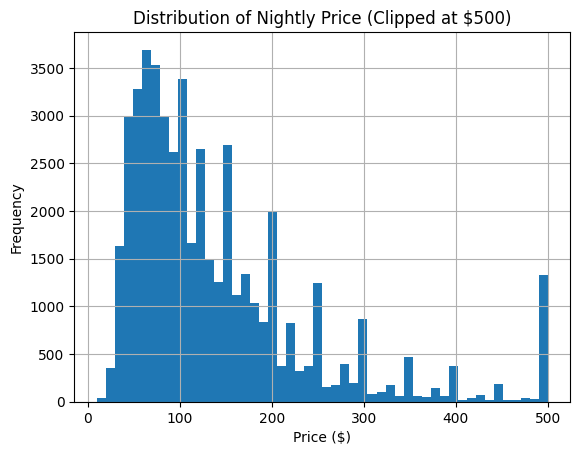

In [25]:
df_clean["price"].clip(upper=500).hist(bins=50)
plt.title("Distribution of Nightly Price (Clipped at $500)")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")

### **Design Notes & Limitations**

- Cleaning logic is tailored to Airbnb-style listings data
- Price outliers are not removed in this pipeline
- Schema validation is intentionally lightweight
- Geospatial validation is not included


### **Next Steps**

- Extend pipeline to additional Airbnb city datasets
- Add unit tests for edge cases
- Integrate with EDA and modeling workflows
